In [1]:
# Standard library import
import re
import warnings
import time
from difflib import get_close_matches

# Scientific computing libraries (third-party libraries)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
import scipy.sparse as sp

# Natural language processing libraries (third-party libraries)
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning and model libraries (third-party libraries)
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split as sk_train_test_split
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split as sp_train_test_split

# Ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# read files
ratings = pd.read_csv('rating.csv') 
movies = pd.read_csv('movie.csv')  
tags = pd.read_csv('tag.csv')  

# Merge rating.csv with movie.csv by movieId, because movieId is the key that uniquely identifies each movie
rating_movie_merged = pd.merge(ratings, movies, on='movieId')
rating_movie_merged.head()

# merge rating_movie and tags
final_merged_data = pd.merge(rating_movie_merged, tags, on=['movieId', 'userId'], how='inner')

# check final dataframe
final_merged_data.head()

,userId,movieId,rating,timestamp_x,title,genres,tag,timestamp_y
0,65,27866,4.0,2011-05-09 16:05:59,In My Father's Den (2004),Drama,New Zealand,2011-05-09 16:05:53
1,65,48082,4.5,2011-05-09 16:26:19,"Science of Sleep, The (La science des rêves) (...",Comedy|Drama|Fantasy|Romance,surreal,2011-05-09 16:25:54
2,65,48082,4.5,2011-05-09 16:26:19,"Science of Sleep, The (La science des rêves) (...",Comedy|Drama|Fantasy|Romance,unusual,2011-05-09 16:25:59
3,65,58652,5.0,2011-05-09 16:09:31,CJ7 (Cheung Gong 7 hou) (2008),Children|Comedy|Sci-Fi,cute,2011-05-09 16:13:32
4,65,58652,5.0,2011-05-09 16:09:31,CJ7 (Cheung Gong 7 hou) (2008),Children|Comedy|Sci-Fi,emotional,2011-05-09 16:13:28


In [3]:
# remove extra timestamp
final_merged_data = final_merged_data.drop(columns=['timestamp_y']).rename(columns={'timestamp_x': 'timestamp'})
final_merged_data.head()

,userId,movieId,rating,timestamp,title,genres,tag
0,65,27866,4.0,2011-05-09 16:05:59,In My Father's Den (2004),Drama,New Zealand
1,65,48082,4.5,2011-05-09 16:26:19,"Science of Sleep, The (La science des rêves) (...",Comedy|Drama|Fantasy|Romance,surreal
2,65,48082,4.5,2011-05-09 16:26:19,"Science of Sleep, The (La science des rêves) (...",Comedy|Drama|Fantasy|Romance,unusual
3,65,58652,5.0,2011-05-09 16:09:31,CJ7 (Cheung Gong 7 hou) (2008),Children|Comedy|Sci-Fi,cute
4,65,58652,5.0,2011-05-09 16:09:31,CJ7 (Cheung Gong 7 hou) (2008),Children|Comedy|Sci-Fi,emotional


In [4]:
# check null value
final_merged_data.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
tag          1
dtype: int64

In [5]:
# mark NaN as 'unknown'
final_merged_data['tag'] = final_merged_data['tag'].fillna('unknown')
final_merged_data.isnull().sum() 

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
tag          0
dtype: int64

In [6]:
final_merged_data.describe()

,userId,movieId,rating
count,391445.000000,391445.000000,391445.000000
mean,67291.897587,32766.306189,3.780652
std,42227.513945,35997.920748,1.024136
min,65.000000,1.000000,0.500000
25%,27898.000000,2502.000000,3.000000
50%,66635.000000,7361.000000,4.000000
75%,106755.000000,63072.000000,4.500000
max,138472.000000,131258.000000,5.000000


In [7]:
# drop duplicate on duplicated rows
final_merged_data = final_merged_data.drop_duplicates(subset=['userId', 'movieId'])

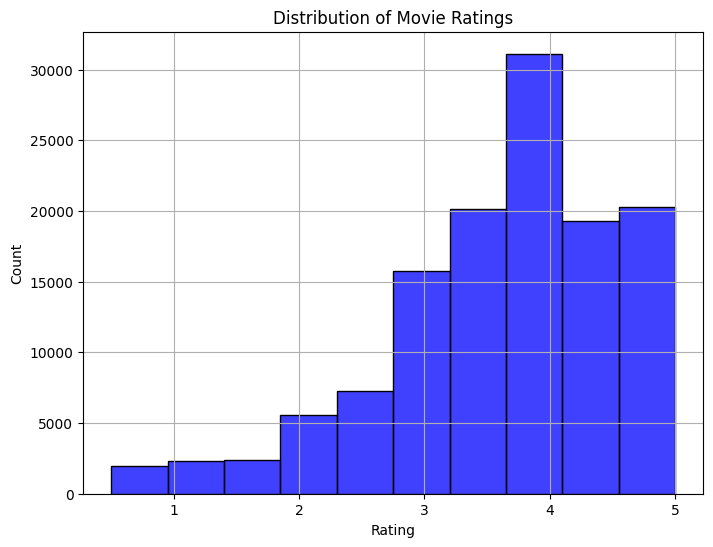

In [8]:
# visualize rating distribution
plt.figure(figsize=(8, 6))
sns.histplot(final_merged_data['rating'], bins=10, kde=False, color='blue', kde_kws={'bw_adjust': 2})
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(True)
plt.show()

This is a positively skewed distribution, i.e. most of the ratings for movies tend to be high. Many users tend to give high ratings (close to 5) to the movies they like, and fewer users give very low ratings (such as 1).

In [9]:
# split genres col, make each genre a list
final_merged_data['genres_split'] = final_merged_data['genres'].str.split('|')

# use explode to show genre as independent row and save the result as a new dataframe
genres_exploded = final_merged_data.explode('genres_split')

# count each genre's appearance
genre_counts = genres_exploded['genres_split'].value_counts()
genre_counts

genres_split
Drama                 62926
Comedy                40755
Thriller              35589
Action                33221
Adventure             24075
Romance               22346
Sci-Fi                22114
Crime                 22103
Fantasy               14305
Mystery               12883
Horror                11437
Animation              7510
Children               7161
War                    6361
IMAX                   6271
Musical                4356
Documentary            2961
Western                1872
Film-Noir              1859
(no genres listed)       18
Name: count, dtype: int64

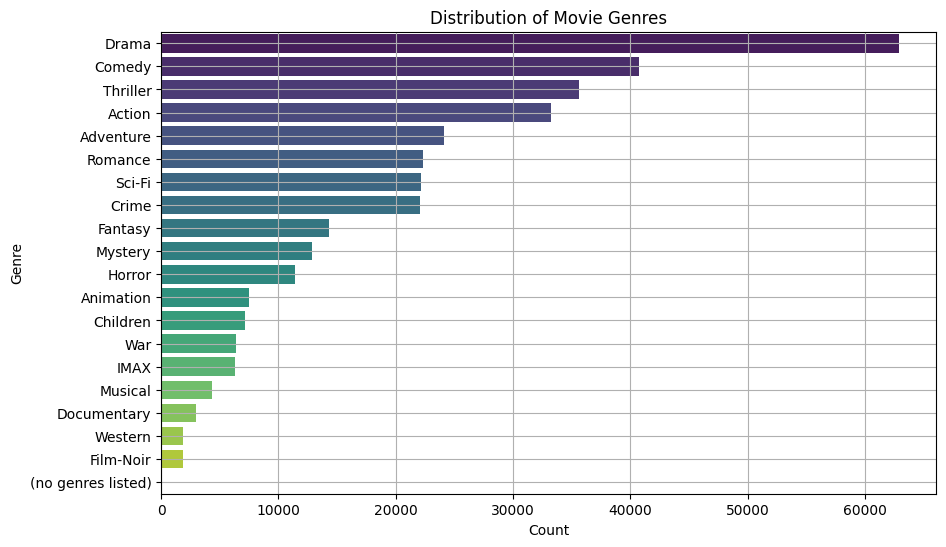

In [10]:
# visualize genre distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Distribution of Movie Genres')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.grid(True)
plt.show()

Most popular movie genre is Drama. Comedy, Thriller, Action is also popular. Film-Noir, Western and  Musical have less audience.

In [11]:
# convert timestamp to datetime format
final_merged_data['timestamp'] = pd.to_datetime(final_merged_data['timestamp'])

# extract year and month
final_merged_data['year'] = final_merged_data['timestamp'].dt.year
final_merged_data['month'] = final_merged_data['timestamp'].dt.month

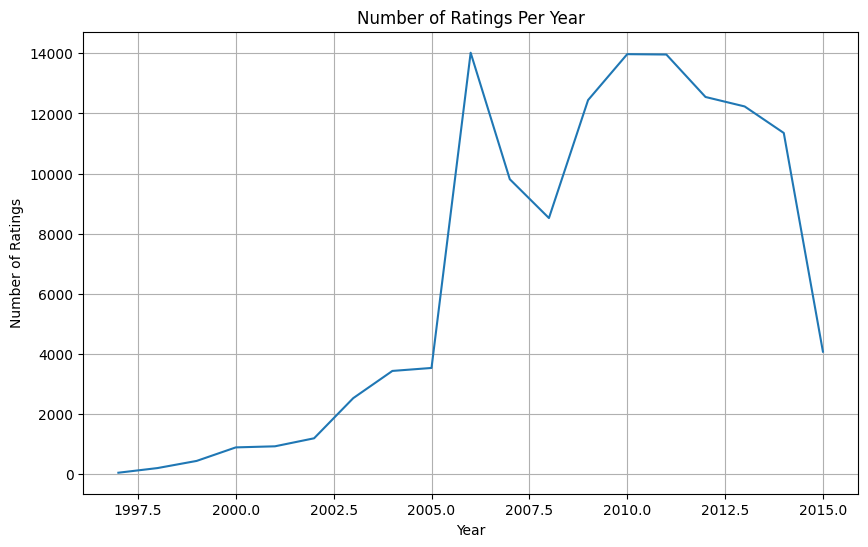

In [12]:
# calculate ratings based on year
ratings_per_year = final_merged_data.groupby('year').size()

# visualize
plt.figure(figsize=(10, 6))
plt.plot(ratings_per_year.index, ratings_per_year.values)
plt.title('Number of Ratings Per Year')
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.show()

There is a sharp increase in the number of ratings between 2005 and 2010, followed by a significant drop after 2011. Such fluctuations may be related to specific events or trends in the dataset, or to changes in the movie recommendation system and user behavior.

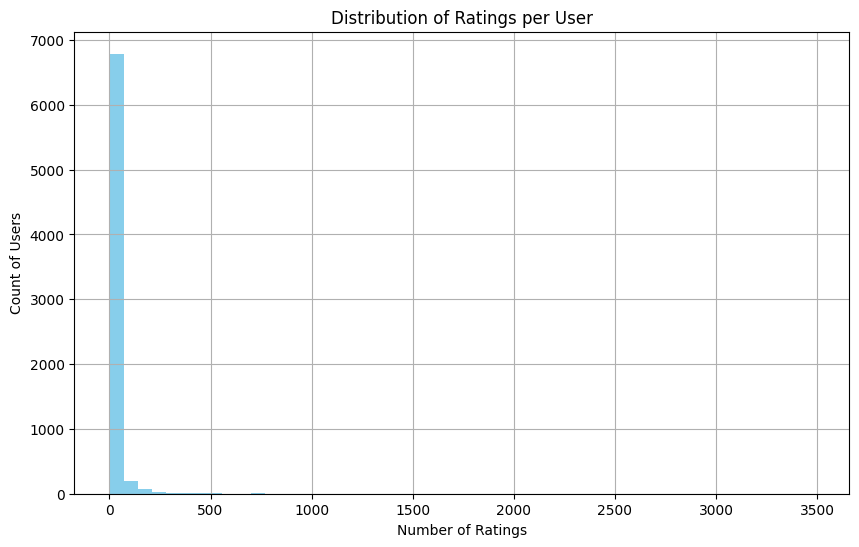

In [13]:
# count the number of ratings for each user 
user_rating_counts = final_merged_data.groupby('userId').size()

# visualize Distribution of Ratings per User
plt.figure(figsize=(10, 6))
plt.hist(user_rating_counts, bins=50, color='skyblue')
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.grid(True)
plt.show()

This is a typical long-tail distribution, where most users have a low number of ratings (less than 100), while a few active users have a large number of ratings.

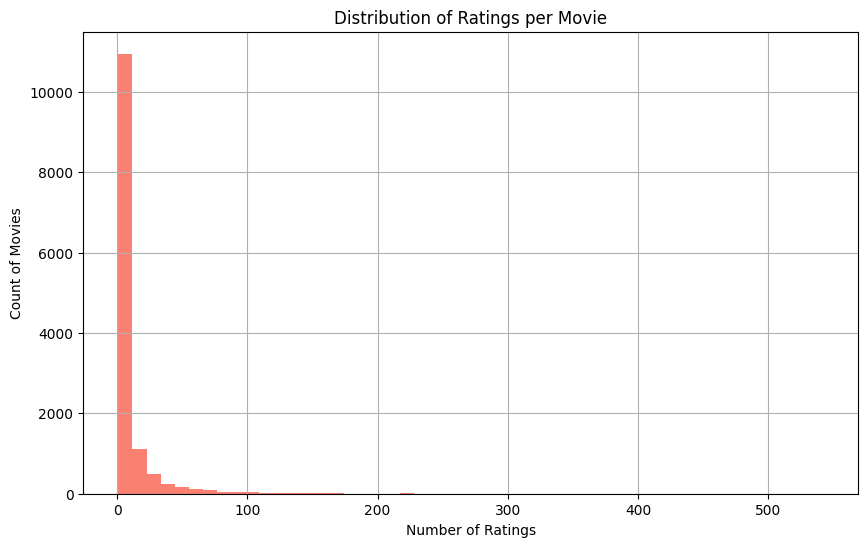

In [14]:
# Count the number of ratings for each movie
movie_rating_counts = final_merged_data.groupby('movieId').size()

# visualize 'Distribution of Ratings per Movie
plt.figure(figsize=(10, 6))
plt.hist(movie_rating_counts, bins=50, color='salmon')
plt.title('Distribution of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.grid(True)
plt.show()

This is also a typical long-tail distribution, where most movies have very few ratings, while a few movies have a very large number of ratings.

In [15]:
# Computing the sparsity of the rating matrix
total_possible_ratings = final_merged_data['userId'].nunique() * final_merged_data['movieId'].nunique()
actual_ratings = len(final_merged_data)
sparsity = 1 - (actual_ratings / total_possible_ratings)
print(f"Sparsity of the rating matrix: {sparsity:.4f}")

Sparsity of the rating matrix: 0.9987


The sparsity of the rating matrix is 0.9959, which means that 99.59% of user-movie pairs have no ratings, and only 0.41% of user-movie pairs have rating data. This shows that the dataset is very sparse, with relatively few ratings, and most users have not rated most movies.

In [16]:
# Filter out users who have rated less than 20 times
active_users = user_rating_counts[user_rating_counts >= 20].index
final_merged_data = final_merged_data[final_merged_data['userId'].isin(active_users)]

# Filter out movies with less than 50 ratings
popular_movies = movie_rating_counts[movie_rating_counts >= 50].index
final_merged_data = final_merged_data[final_merged_data['movieId'].isin(popular_movies)]

In [17]:
# Computing the sparsity of the rating matrix again
total_possible_ratings = final_merged_data['userId'].nunique() * final_merged_data['movieId'].nunique()
actual_ratings = len(final_merged_data)
sparsity = 1 - (actual_ratings / total_possible_ratings)
print(f"Sparsity of the rating matrix: {sparsity:.4f}")

Sparsity of the rating matrix: 0.9333


Sparsity got improved.

In [18]:
# LabelEncoder for userId 
user_encoder = LabelEncoder()
final_merged_data['userId_encoded'] = user_encoder.fit_transform(final_merged_data['userId'])

# LabelEncoder for movieId:
movie_encoder = LabelEncoder()
final_merged_data['movieId_encoded'] = movie_encoder.fit_transform(final_merged_data['movieId'])

# check data after labelencoding
final_merged_data[['userId', 'userId_encoded', 'movieId', 'movieId_encoded']].head()

,userId,userId_encoded,movieId,movieId_encoded
102,129,0,2706,191
109,129,0,3556,219
122,129,0,4878,247
145,129,0,8641,323
196,129,0,80549,478


In [19]:
# Start the timer
start_time = time.time()

# Define the rating scale and prepare the dataset
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(final_merged_data[['userId_encoded', 'movieId_encoded', 'rating']], reader)

# Define the parameter grid for SVD
param_grid = {
    'n_factors': [50, 100],  # Reduce the number of factors
    'n_epochs': [20, 30],    # Reduce the number of epochs
    'lr_all': [0.005],       # Fix the learning rate to a single value
    'reg_all': [0.02]        # Fix the regularization parameter to a single value
}

# Perform GridSearchCV for parameter tuning (using Surprise's GridSearchCV)
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

# Fit GridSearchCV on the dataset
grid_search.fit(data)

# Output the best parameters based on RMSE
print("Best RMSE score:", grid_search.best_score['rmse'])
print("Best parameters for SVD model:", grid_search.best_params['rmse'])

# Train the final model with the best parameters
best_svd = grid_search.best_estimator['rmse']
trainset = data.build_full_trainset()
best_svd.fit(trainset)

# Perform predictions on the test set (train/test split is done inside the GridSearchCV)
testset = trainset.build_anti_testset()
predictions = best_svd.test(testset)

# Evaluate the model performance
accuracy.rmse(predictions)
accuracy.mae(predictions)

# End the timer
end_time = time.time()

# Calculate the total time taken
elapsed_time = end_time - start_time
print(f"Total execution time: {elapsed_time:.2f} seconds")

Best RMSE score: 0.8037720371577949
Best parameters for SVD model: {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.02}
RMSE: 0.4922
MAE:  0.3804
Total execution time: 8.95 seconds


The RMSE and MAE results show that the prediction error of the model is within a reasonable range, indicating that the performance of the model is good.

In [20]:
# generate movie recommendations for specific user
def recommend_movies(user_id, final_merged_data, svd_model, n_recommendations=5):
    """Generate movie recommendations for a specific user based on the SVD model."""
    # Get movies the user has already rated
    user_rated_movies = final_merged_data[final_merged_data['userId_encoded'] == user_id]['movieId_encoded'].values
    all_movies = final_merged_data['movieId_encoded'].unique()
    
    # Filter out movies the user has already rated
    unrated_movies = [movie for movie in all_movies if movie not in user_rated_movies]
    
    # Generate predictions for unrated movies
    recommendations = []
    for movie_id in unrated_movies[:n_recommendations]:
        prediction = svd_model.predict(user_id, movie_id)
        movie_title = final_merged_data[final_merged_data['movieId_encoded'] == movie_id]['title'].values[0]
        recommendations.append((movie_title, prediction.est))
    
    return recommendations

# Use the recommend_movies function with the trained model (best_svd, not svd)
recommendations = recommend_movies(user_id=121, final_merged_data=final_merged_data, svd_model=best_svd)
for title, score in recommendations:
    print(f"Movie: {title}, predict: {score}")

Movie: American Pie (1999), predict: 2.332593689277614
Movie: Virgin Suicides, The (1999), predict: 3.2032134381437047
Movie: Donnie Darko (2001), predict: 3.329224930391829
Movie: Anchorman: The Legend of Ron Burgundy (2004), predict: 2.7697907144239293
Movie: Easy A (2010), predict: 2.8046249429099492


In [21]:
# use MultiLabelBinarizer to One-Hot encode genres

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(final_merged_data['genres_split'])

# convert the result of One-Hot to DataFrame and add it to the original dataset
genres_encoded_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
final_merged_data = pd.concat([final_merged_data, genres_encoded_df], axis=1)

# delete the original genres column and genres_split coloumn
final_merged_data.drop(['genres', 'genres_split'], axis=1, inplace=True)
final_merged_data.head()

,userId,movieId,rating,timestamp,title,tag,year,month,userId_encoded,movieId_encoded,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
102,129.0,2706.0,3.0,2011-03-06 23:14:32,American Pie (1999),high school,2011.0,3.0,0.0,191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
109,129.0,3556.0,4.0,2011-03-14 03:17:33,"Virgin Suicides, The (1999)",great ending,2011.0,3.0,0.0,219.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
122,129.0,4878.0,5.0,2011-04-04 03:10:34,Donnie Darko (2001),alternate timeline,2011.0,4.0,0.0,247.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
145,129.0,8641.0,3.5,2011-02-08 05:55:08,Anchorman: The Legend of Ron Burgundy (2004),Ben Stiller,2011.0,2.0,0.0,323.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,129.0,80549.0,3.0,2011-01-17 21:15:23,Easy A (2010),Emma Stone,2011.0,1.0,0.0,478.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [22]:
final_merged_data['movieId'].values

array([2706., 3556., 4878., ...,   nan,   nan,   nan])

In [28]:
# generate movie recommendations based on similar content

def get_movie_id_from_title(title, final_merged_data):
    """
    Returns the movieId corresponding to the closest matching title.
    
    Parameters:
    title (str): The title of the movie.
    final_merged_data (DataFrame): The DataFrame containing the movie data.
    
    Returns:
    movie_id (int): The ID of the closest matching movie title.
    """
    # Drop rows where the 'title' column is NaN
    final_merged_data = final_merged_data.dropna(subset=['title'])
    
    # Get all available titles
    all_titles = final_merged_data['title'].tolist()
    
    # Use difflib's get_close_matches to find the closest matching title
    closest_matches = get_close_matches(title, all_titles, n=1, cutoff=0.5)
    
    if closest_matches:
        matched_title = closest_matches[0]
        # Get the corresponding movieId for the closest match
        movie_id = final_merged_data[final_merged_data['title'] == matched_title]['movieId'].values[0]
        return movie_id, matched_title
    else:
        raise ValueError(f"No movie found with a title similar to '{title}'.")

def recommend_movies_based_on_genres(movie_id, final_merged_data, n_recommendations=5):
    """
    Recommends movies based on genres similarity using cosine similarity.
    
    Parameters:
    movie_id (int): The ID of the movie for which to recommend similar movies.
    final_merged_data (DataFrame): The DataFrame containing the merged movie data with one-hot encoded genres.
    n_recommendations (int): The number of similar movie recommendations to return.
    
    Returns:
    List of recommended movies (title, similarity score)
    """
    
    # Drop rows that contain any NaN values
    final_merged_data = final_merged_data.dropna()

    # Select only numeric columns (which should include the one-hot encoded genres columns)
    genre_columns = final_merged_data.select_dtypes(include=[np.number]).columns.tolist()
    
    # Ensure the movie_id exists in the dataset
    if movie_id not in final_merged_data['movieId'].values:
        raise ValueError(f"Movie ID {movie_id} not found in the dataset.")
    
    # Get the index of the movie
    movie_idx = final_merged_data[final_merged_data['movieId'] == movie_id].index[0]
    
    # Get the genres vector for the target movie
    movie_vector = final_merged_data.loc[movie_idx, genre_columns].values.reshape(1, -1)
    
    # Compute cosine similarity between this movie and all other movies
    similarity_scores = cosine_similarity(movie_vector, final_merged_data[genre_columns].values).flatten()
    
    # Get the indices of the most similar movies, excluding itself
    similar_indices = similarity_scores.argsort()[::-1][1:n_recommendations+1]
    
    # Get movie titles and similarity scores
    recommended_movies = []
    for idx in similar_indices:
        movie_title = final_merged_data.iloc[idx]['title']
        similarity_score = similarity_scores[idx]
        recommended_movies.append((movie_title, similarity_score))
    
    return recommended_movies

def recommend_movies_based_on_genres_by_title(movie_title, final_merged_data, n_recommendations=5):
    """
    Recommends movies based on genres similarity using cosine similarity, searched by movie title.
    
    Parameters:
    movie_title (str): The title of the movie for which to recommend similar movies.
    final_merged_data (DataFrame): The DataFrame containing the merged movie data with one-hot encoded genres.
    n_recommendations (int): The number of similar movie recommendations to return.
    
    Returns:
    List of recommended movies (title, similarity score)
    """
    
    # Get the movie ID and matched title from the movie title
    movie_id, matched_title = get_movie_id_from_title(movie_title, final_merged_data)
    
    # Proceed with recommendations based on movie ID
    recommendations = recommend_movies_based_on_genres(movie_id, final_merged_data, n_recommendations + 1)  # Get one extra in case the input movie appears
    
    # Filter out the movie that matches the search input (if present in recommendations)
    filtered_recommendations = [(title, score) for title, score in recommendations if title != matched_title]
    
    return filtered_recommendations[:n_recommendations]  # Return exactly the requested number of recommendations

# Example usage:
movie_title = "Inception"  # Example movie title
recommended_movies = recommend_movies_based_on_genres_by_title(movie_title, final_merged_data, n_recommendations=5)

# Print recommendations
for title, score in recommended_movies:
    print(f"Movie: {title}, Similarity: {score:.4f}")

Movie: Scott Pilgrim vs. the World (2010), Similarity: 1.0000
Movie: Mr. Nobody (2009), Similarity: 1.0000
Movie: Tron: Legacy (2010), Similarity: 1.0000
Movie: Shutter Island (2010), Similarity: 1.0000
Movie: Social Network, The (2010), Similarity: 1.0000


In [ ]:
# define stopwords
stop_words = set(stopwords.words('english'))

# preprocess the text
def preprocess_tags(text):
    text = text.lower() # convert text to lower
    text = re.sub(r'[^\w\s]', '', text) # remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words]) # remove stopwords
    return text

# preprocess tag column
final_merged_data['tags_processed'] = final_merged_data['tag'].fillna('').apply(preprocess_tags)

# use TF-IDF to vectorize `tags` colomn 
tfidf = TfidfVectorizer(max_features=1000)
tags_tfidf_matrix = tfidf.fit_transform(final_merged_data['tags_processed'])

In [ ]:
# Check the data type of each column
final_merged_data.dtypes

In [ ]:
# define target first to prevent data leakage
y = final_merged_data['rating'].values

# Delete non-numeric columns (such as 'title', 'tag', 'timestamp', 'tags_processed') and target
final_merged_data_numeric = final_merged_data.drop(columns=['title', 'tag', 'timestamp', 'tags_processed', 'rating'])

# Convert the processed numerical features into a sparse matrix
final_merged_data_sparse = sp.csr_matrix(final_merged_data_numeric.values)

# Merge the numerical sparse matrix and the TF-IDF sparse matrix
final_merged_data_combined = sp.hstack([final_merged_data_sparse, tags_tfidf_matrix])

In [ ]:
# define features 
X = final_merged_data_combined  

# train test split
X_train, X_test, y_train, y_test = sk_train_test_split(X, y, test_size=0.2, random_state=42)

# check shape
print(X_train.shape)
print(X_test.shape)